# Profiles of T/s anomalies

### input files

In [39]:


#time domain
yrst = 2006 ; yren  = 2025
clst = yrst ; clen = 2018


# # EN4
# src  = 'EN4'
# diri = '/g/data/gv90/wrh581/'
# prefix = src+'/EN.4.2.2.?.analysis.l09.'
# sNam = 'salinity' ; tNam = 'temperature'   #variable names


# ORAS5
src  = 'ORAS5'
diri = '/g/data/gv90/wrh581/ORAS5/'  #'/g/data/lo70/hs5546/ORAS5/*/'
sNam = 'vosaline' ; tNam = 'votemper'   #variable names

#output directory
diro = 'gd/Obs-seaice-analysis/plots/'

### time/space sector definitions

In [40]:



#depth
zmin = 0. ; zmax = 400.


#sectors
sector = {
        'Circumpolar' : {'minlon' : 0.,  'maxlon' : 360., 'minlat' : -65., 'maxlat' : -55},
#        'Atl_hemi' : {'minlon' : 300., 'maxlon' : 90.,  'minlat' : -70., 'maxlat' : -60.},
#        'E. Antarctic' : {'minlon' : 30., 'maxlon' : 60.,  'minlat' : -65., 'maxlat' : -62.},
        'Bellingshausen' : {'minlon' : 277.,  'maxlon' : 295., 'minlat' : -72., 'maxlat' : -65},
        'Weddell' : {'minlon' : 327., 'maxlon' : 10.,  'minlat' : -65., 'maxlat' : -59.},
        'King Haakon' : {'minlon' : 10., 'maxlon' : 70., 'minlat' : -75., 'maxlat' : -55.}
#        'Greenwich_merid' : {'minlon' : 350., 'maxlon' : 370.,  'minlat' : -65., 'maxlat' : -55.},
    
}




In [41]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import xarray as xr
import cf_xarray as cf
import pandas as pd
import gsw              #TEOS-10 package
import cmocean as cm
import calendar


import logging
logging.getLogger("flox").setLevel(logging.WARNING) #tell flox to get floxed!

import sys
sys.path.append('/g/data/jk72/wrh581/Southern-Ocean-ice-potential')
import zcrit_Hcrit_calc as zcalc
#method of calculating Freeze condition aka SaFT 
SaFT_method = zcalc.freeze_condition_continuous

from dask.distributed import Client
Client=Client(threads_per_worker = 1, memory_limit = 0)
#Client

### Read T/S data

In [42]:


if (src == 'EN4'):

    #get file list for all years and months in range
    yrstring = [str(yr) for yr in  np.arange(yrst,yren+1) ]        #string list of years
    cmd = 'ls '+diri+prefix+'{'+','.join(yrstring)+'}??.nc 2>/dev/null'  #unix command
    fpath = !$cmd


    data = xr.open_mfdataset(fpath, chunks = -1, parallel=True).cf.sel(vertical = slice(zmin, zmax))

    #add area
    data = data.assign({'wgts' : (data.cf['latitude'].name,   np.cos(np.deg2rad(data.cf['latitude'].values)))}) 

        
    #add some attributes    
    data[sNam].attrs['units'] = 'PSU'
    data[tNam].attrs['units'] = 'K'
    data[tNam].attrs['long_name'] = 'Potential temperature'

elif (src == 'ORAS5'):
    

    def read_ORAS5(var):
        yrstring = [str(yr) for yr in  np.arange(yrst,yren+1) ]        #string list of years
        cmd = 'ls '+diri+var+'/ORAS5_'+var+'_monthly_SOcean_{'+','.join(yrstring)+'}.nc 2>/dev/null'  #unix command
        fpath = !$cmd

        def _ora_preprocess(ds):
            da = ds[var].sel(deptht = slice(zmin,zmax)).isel(x = slice(0,1440))    #bug in ORAS5 data, 'vertical' is not included in the CF dictionary
            return da.where(da['nav_lat'].compute() < -50., drop = True)
          
        return xr.open_mfdataset(fpath,preprocess = _ora_preprocess, chunks = { 'y' :  100,'x' : -1},  parallel=True)[var]#.chunk({'deptht' : 15})


        
    data = xr.Dataset({
        tNam : read_ORAS5(tNam),
        sNam : read_ORAS5(sNam)
    })

    #add area weights
    data =  data.assign({'wgts' : (data.cf['latitude'].dims,   np.cos(np.deg2rad(data.cf['latitude'].values)))}) 

    #rename time coord
    data = data.rename({ data.cf['time'].name : 'time'})

    #add correct attribute to temperature var
    data[tNam].attrs['long_name'] = 'Potential temperature'

data

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
/g/d

<xarray.Dataset> Size: 27GB
Dimensions:   (deptht: 37, y: 267, x: 1440, time: 235)
Coordinates:
  * deptht    (deptht) float32 148B 0.5058 1.556 2.668 ... 300.9 333.9 370.7
    nav_lat   (y, x) float32 2MB -77.01 -77.01 -77.01 ... -50.06 -50.06 -50.06
    nav_lon   (y, x) float32 2MB 72.75 73.0 73.25 73.5 ... 71.75 72.0 72.25 72.5
  * time      (time) datetime64[ns] 2kB 2006-01-16 ... 2025-07-16T12:00:00
Dimensions without coordinates: y, x
Data variables:
    votemper  (time, deptht, y, x) float32 13GB dask.array<chunksize=(12, 37, 79, 1440), meta=np.ndarray>
    vosaline  (time, deptht, y, x) float32 13GB dask.array<chunksize=(12, 37, 79, 1440), meta=np.ndarray>
    wgts      (y, x) float32 2MB 0.2248 0.2248 0.2248 ... 0.642 0.642 0.642

### Get sector means

In [43]:
#reset sector def. longitudes (e.g. MOM coords)
pivot = data.cf['longitude'].min().values
if (pivot < 0.):
    pivot = data.cf['longitude'].max().values
    def MOMlon(lon):
        if (lon > pivot): lon = lon - 360.
        return(lon)

    for i in sector:
        xrange              = sector[i]['maxlon'] - sector[i]['minlon']
        #circumpolar special case
        if xrange == 360.:
            sector[i]['minlon'] = -pivot
            sector[i]['maxlon'] = pivot
        else:
            sector[i]['minlon'] = MOMlon(sector[i]['minlon'])
            sector[i]['maxlon'] = MOMlon(sector[i]['maxlon'])



In [44]:

dSiz  = data[tNam].shape    #dimension sizes
dNams = data[tNam].dims           #dimension names
zNam = dNams[1] ; yNam = dNams[2] ; xNam = dNams[3] # make the dim names a bit more 'readable' later



#new dataset to hold sector means (dimensioned time, depth, sector(
nsec = len(sector)
try: 
    sector_mean = data.isel(**{yNam : range(nsec), xNam : 0}).drop_vars(xNam) 
except:
    sector_mean = data.isel(**{yNam : range(nsec), xNam : 0})
sector_mean = sector_mean.rename({ yNam : 'sector'})
sector_mean = sector_mean.assign_coords({'sector' : list(sector.keys())}) #sector names become coords


for sname in sector:
    xmin = sector[sname]['minlon']
    xmax = sector[sname]['maxlon']
    ymin = sector[sname]['minlat']
    ymax = sector[sname]['maxlat']

    #spatial selection (use 'where' in case there's a 2-d lat/lon
    #latitde
    tmp = data.where((data.cf['latitude'] > ymin) & (data.cf['latitude'] <= ymax))
    
    if xmin < xmax:
        tmp = tmp.where((tmp.cf['longitude'] <= xmax) & (tmp.cf['longitude'] > xmin))
    else:
        #this covers case where sector crosses the longitude pivot point
        tmp = tmp.where((tmp.cf['longitude'] <= xmax) | (tmp.cf['longitude'] > xmin))
            
    #weighted mean
    for var in [tNam,sNam]:
        tmp[var] = tmp[var].weighted(tmp.wgts.fillna(0)).mean((yNam, xNam),skipna=True)
        sector_mean[var].loc[{'sector' : sname}] = tmp[var]



sector_mean = sector_mean.chunk(-1)
sector_mean


<xarray.Dataset> Size: 281kB
Dimensions:   (deptht: 37, sector: 4, time: 235)
Coordinates:
  * deptht    (deptht) float32 148B 0.5058 1.556 2.668 ... 300.9 333.9 370.7
    nav_lat   (sector) float32 16B dask.array<chunksize=(4,), meta=np.ndarray>
    nav_lon   (sector) float32 16B dask.array<chunksize=(4,), meta=np.ndarray>
  * time      (time) datetime64[ns] 2kB 2006-01-16 ... 2025-07-16T12:00:00
  * sector    (sector) <U14 224B 'Circumpolar' ... 'King Haakon'
Data variables:
    votemper  (time, deptht, sector) float32 139kB dask.array<chunksize=(235, 37, 4), meta=np.ndarray>
    vosaline  (time, deptht, sector) float32 139kB dask.array<chunksize=(235, 37, 4), meta=np.ndarray>
    wgts      (sector) float32 16B dask.array<chunksize=(4,), meta=np.ndarray>

In [45]:
sector_mean = sector_mean.compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 18.72 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


### various data transformations/corrections

In [46]:

#calc P
P = gsw.p_from_z(-sector_mean[zNam], -65.)


#convert Practical to Absolute Salinity if required
if np.isin(sector_mean[sNam].units, ['psu','PSU',1]): 
    for sname in sector:
        sector_mean[sNam].loc[{'sector' : sname}].values = gsw.SA_from_SP(sector_mean[sNam].sel({'sector' : sname}) ,P,
                                       np.mean((sector[sname]['minlon'],sector[sname]['maxlon'] )), 
                                      np.mean((sector[sname]['minlat'],sector[sname]['maxlat']))) 


#convert tenmperature from K to Celsius
if np.isin(sector_mean[tNam].units, ['K','kelvin']):
    sector_mean[tNam].values = sector_mean[tNam].values - 273.15
    sector_mean[tNam].attrs['units'] = 'degC'

#convert potential temperature to conservative temperature
if sector_mean[tNam].long_name == 'Potential temperature':
    sector_mean[tNam].values = gsw.CT_from_pt(sector_mean[sNam].values, sector_mean[tNam].values)


#add local surface freezing temperature (might be useful for plotting
sector_mean = sector_mean.assign(Tf = gsw.CT_freezing(sector_mean[sNam].isel(**{zNam : 0}) , 0., 0.))




### Calculate 'freeze condition' (i.e. where dS/dz can maintain water at freezing temperature), and related critical depths

In [47]:
# Calc SafT using library function


sector_mean = xr.merge([sector_mean, 
                        SaFT_method(sector_mean[tNam], sector_mean[sNam], 1, sector_mean['Tf'])])


zcrits = zcalc.zcrit_calc_exact(sector_mean['frcon'], zNam)

#sp is seasonal pycnocline (SaFT version of mixed layer depth)
#pp is effectively base of WW/CDW interface (PP = Permanent Pycnocline)
sector_mean = sector_mean.assign({'zcrit_sp' : zcrits[0],  'zcrit_pp' : zcrits[1]}) 

sector_mean.load()

<xarray.Dataset> Size: 1MB
Dimensions:   (deptht: 37, time: 235, sector: 4)
Coordinates:
  * deptht    (deptht) float32 148B 0.5058 1.556 2.668 ... 300.9 333.9 370.7
  * time      (time) datetime64[ns] 2kB 2006-01-16 ... 2025-07-16T12:00:00
  * sector    (sector) <U14 224B 'Circumpolar' ... 'King Haakon'
    nav_lat   (sector) float32 16B -77.01 -76.95 -76.9 -76.84
    nav_lon   (sector) float32 16B 72.75 72.75 72.75 72.75
Data variables:
    votemper  (time, deptht, sector) float64 278kB 2.6 0.1775 ... 0.4334 1.311
    vosaline  (time, deptht, sector) float32 139kB 33.81 32.73 ... 34.69 34.67
    wgts      (sector) float32 16B 0.2248 0.2257 0.2267 0.2277
    Tf        (time, sector) float64 8kB -1.838 -1.775 -1.834 ... -1.861 -1.853
    dS_term   (time, deptht, sector) float64 278kB -9.276e-08 -7.978e-07 ... nan
    dT_term   (time, deptht, sector) float64 278kB 0.0003455 8.912e-05 ... nan
    frcon     (time, deptht, sector) float64 278kB 0.0003454 8.833e-05 ... nan
    zcrit_sp  (time, sector) float64 8kB nan 9.563 22.8 nan ... 41.82 54.12 nan
    zcrit_pp  (time, sector) float64 8kB nan 33.01 109.2 nan ... 75.99 110.9 nan

### plot of T, S, SaFT sector_mean

In [48]:

def sector_anom_plot(plot_sector):

    nrow = 2 ; ncol = 1
    plt.figure(figsize=(20,20), dpi=300)

    selcrit = {'sector' : plot_sector}
    #sector_meanatology (top row)
    colmap = ['',cm.cm.balance, cm.cm.delta]  
    cmax   = ['',0.5, 0.1]  


    
    lcols  = ['magenta','black'] 
    lthck = 3.


    pref = ['','a) T anom','b) S anom']
    cbarlabel = ['','$^o$C','gkg$^{-1}$']



    i = 1
    for var in [tNam, sNam]:
        
        ax = plt.subplot(nrow, ncol, i)

        #subset data
        pdata = sector_mean[var].sel(**selcrit)

        #anomaly
        pdata = pdata.groupby('time.month') - pdata.groupby('time.month').mean ('time')  
        
        cplot = pdata.transpose().plot(ax = ax, vmin = -cmax[i], vmax = cmax[i], cmap = colmap[i],yincrease=False)
        cplot.colorbar.set_label(cbarlabel[i],fontsize=25)
     

        #add critical depth lines
        j = 0
        for line in ['zcrit_sp','zcrit_pp']:
            sector_mean[line].sel(**selcrit).plot(ax=ax, color=lcols[j], linewidth=lthck)
            j = j+1

        #panel title
        plt.title('') ; plt.title(pref[i], loc='left', fontsize = 30)

        #axis labels/tickmarks
        plt.ylabel('depth (m)', fontsize=25) ; plt.xlabel('')
        plt.xticks(fontsize = 20) ; plt.yticks(fontsize=20)
        i = i+1
        
 
     #shared heading
    title = src+' '+plot_sector+' ('+str(sector[plot_sector]['minlon'])+'-'+str(sector[plot_sector]['maxlon'])+'$^o$E ; '+str(sector[plot_sector]['minlat'])+'-'+str(sector[plot_sector]['maxlat'])+'$^o$N )'
    plt.suptitle(title, fontsize=35)


    plt.tight_layout()

In [49]:
# splot = 'Greenwich_merid'
# sector_anom_plot(splot)
# plt.savefig(diro+src+'_'+splot+'_depth-time_sector_mean_anoms.png')

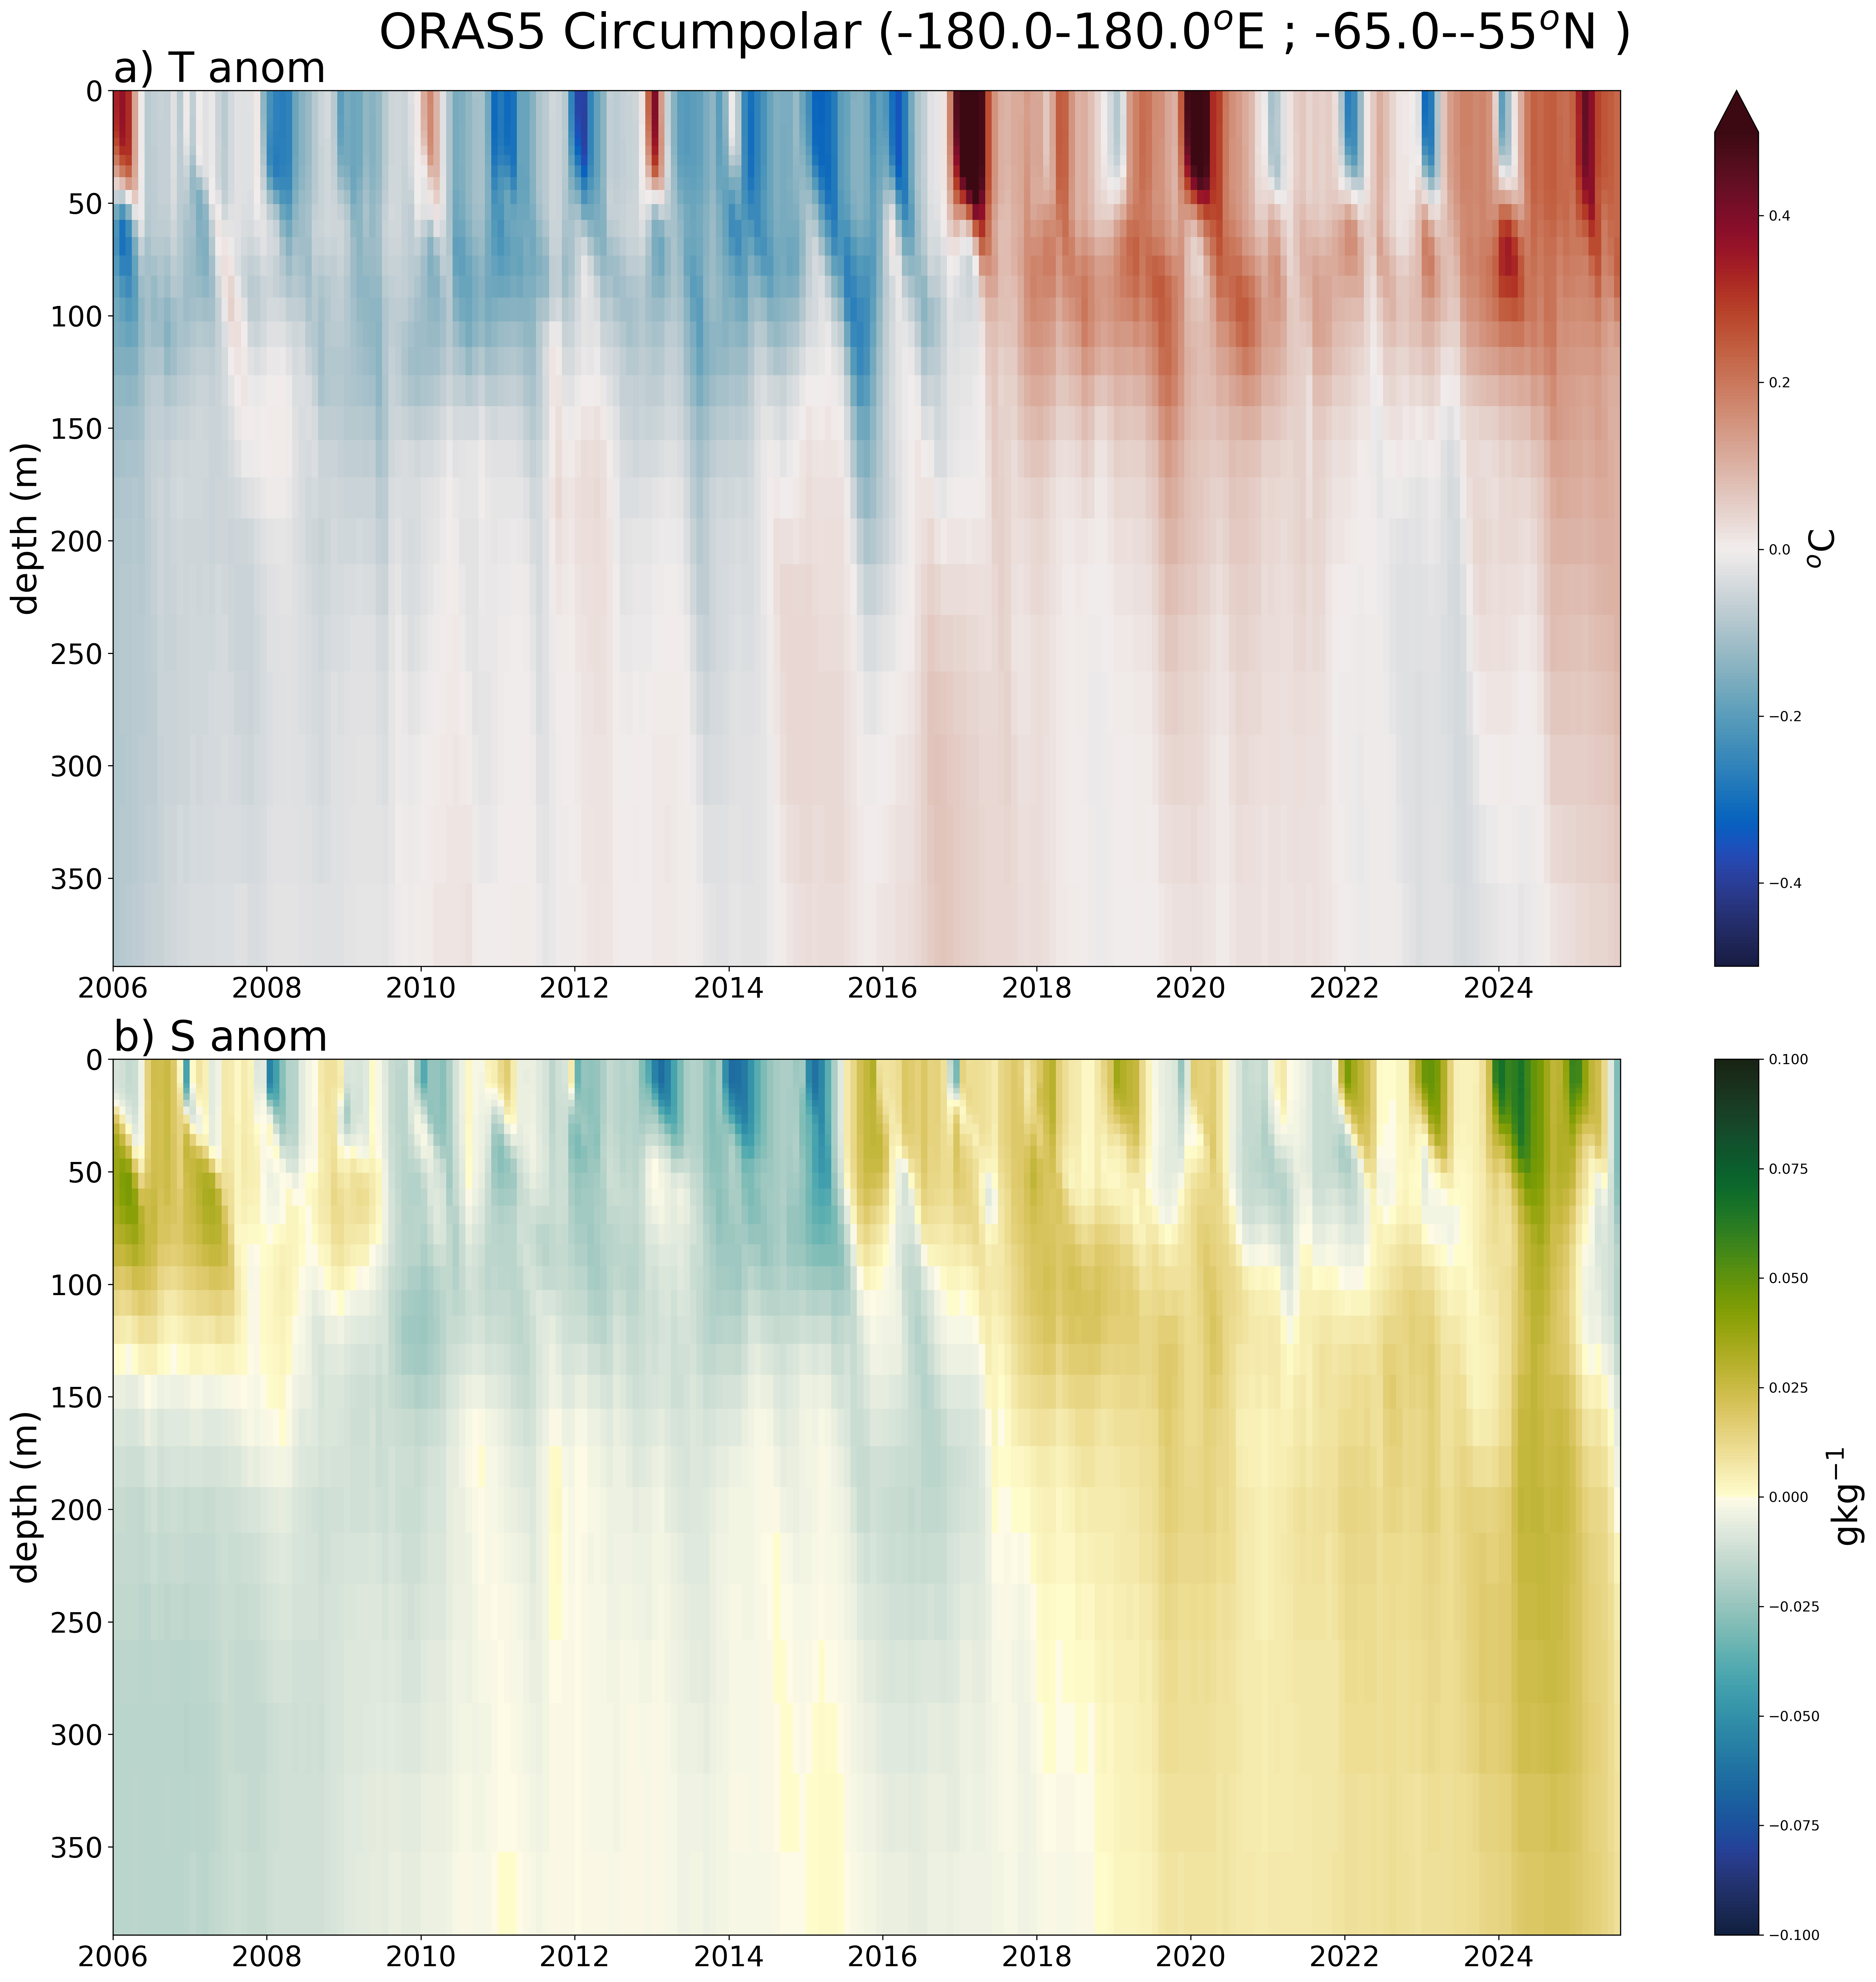

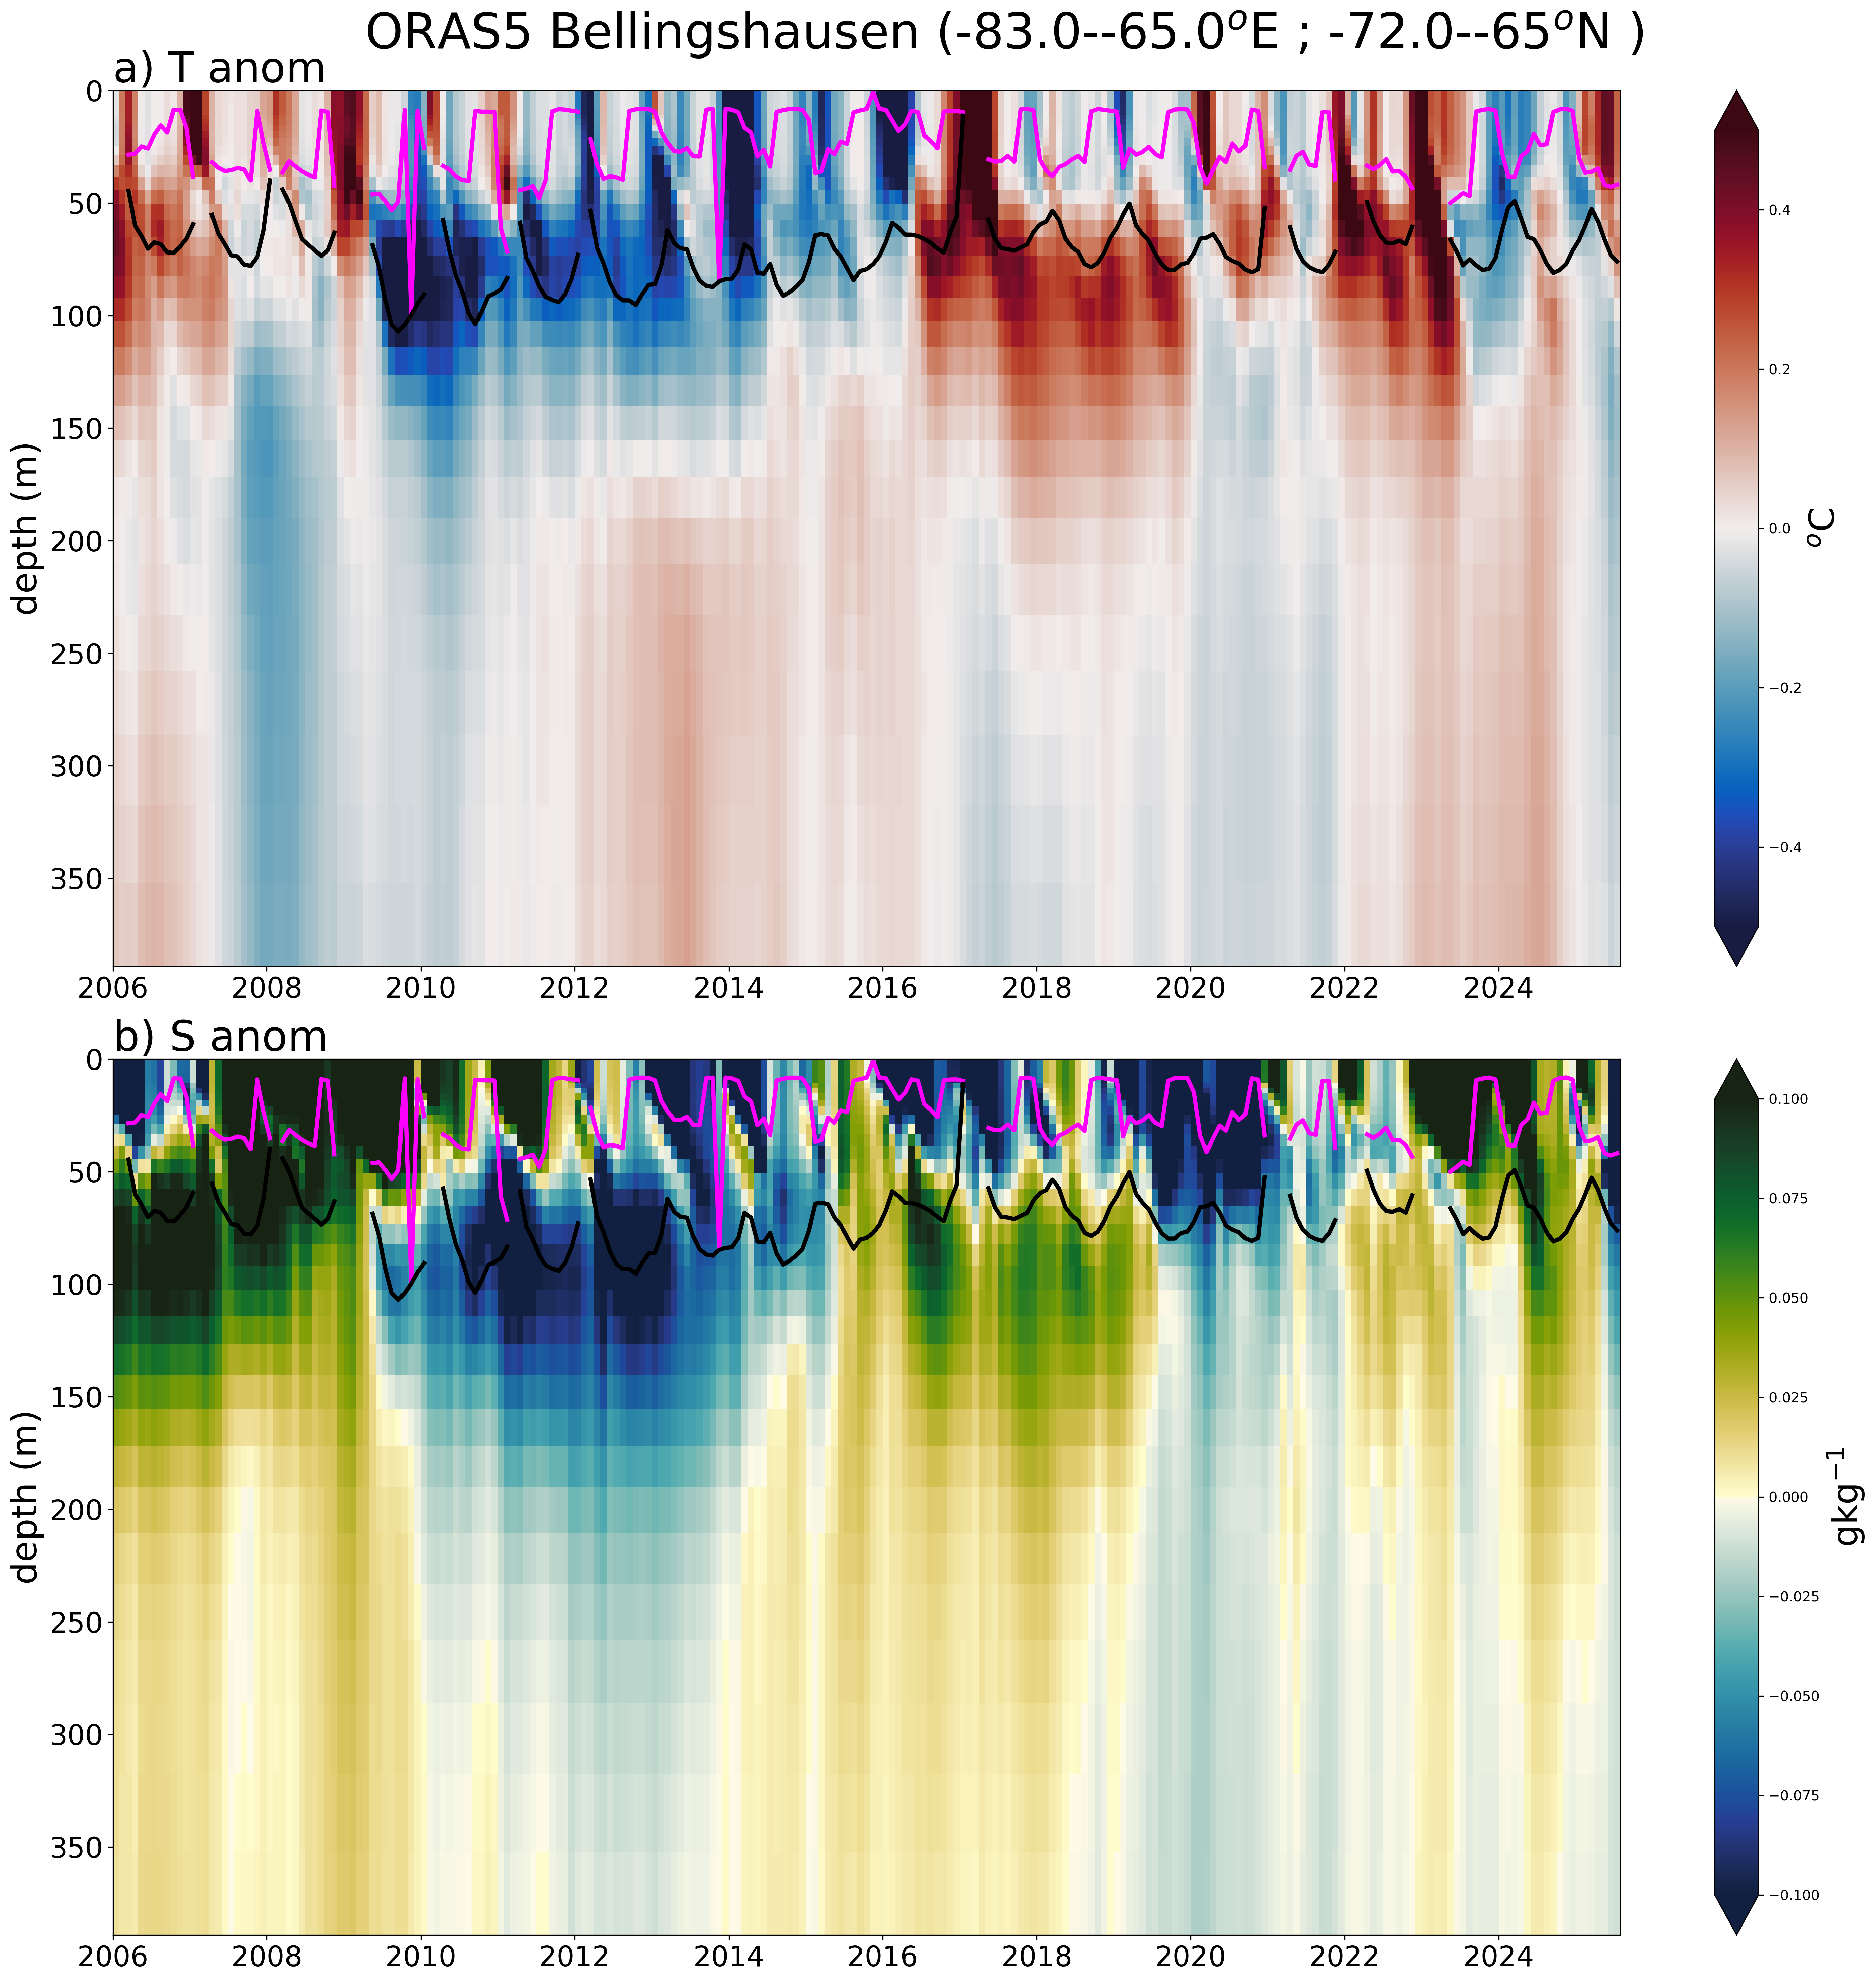

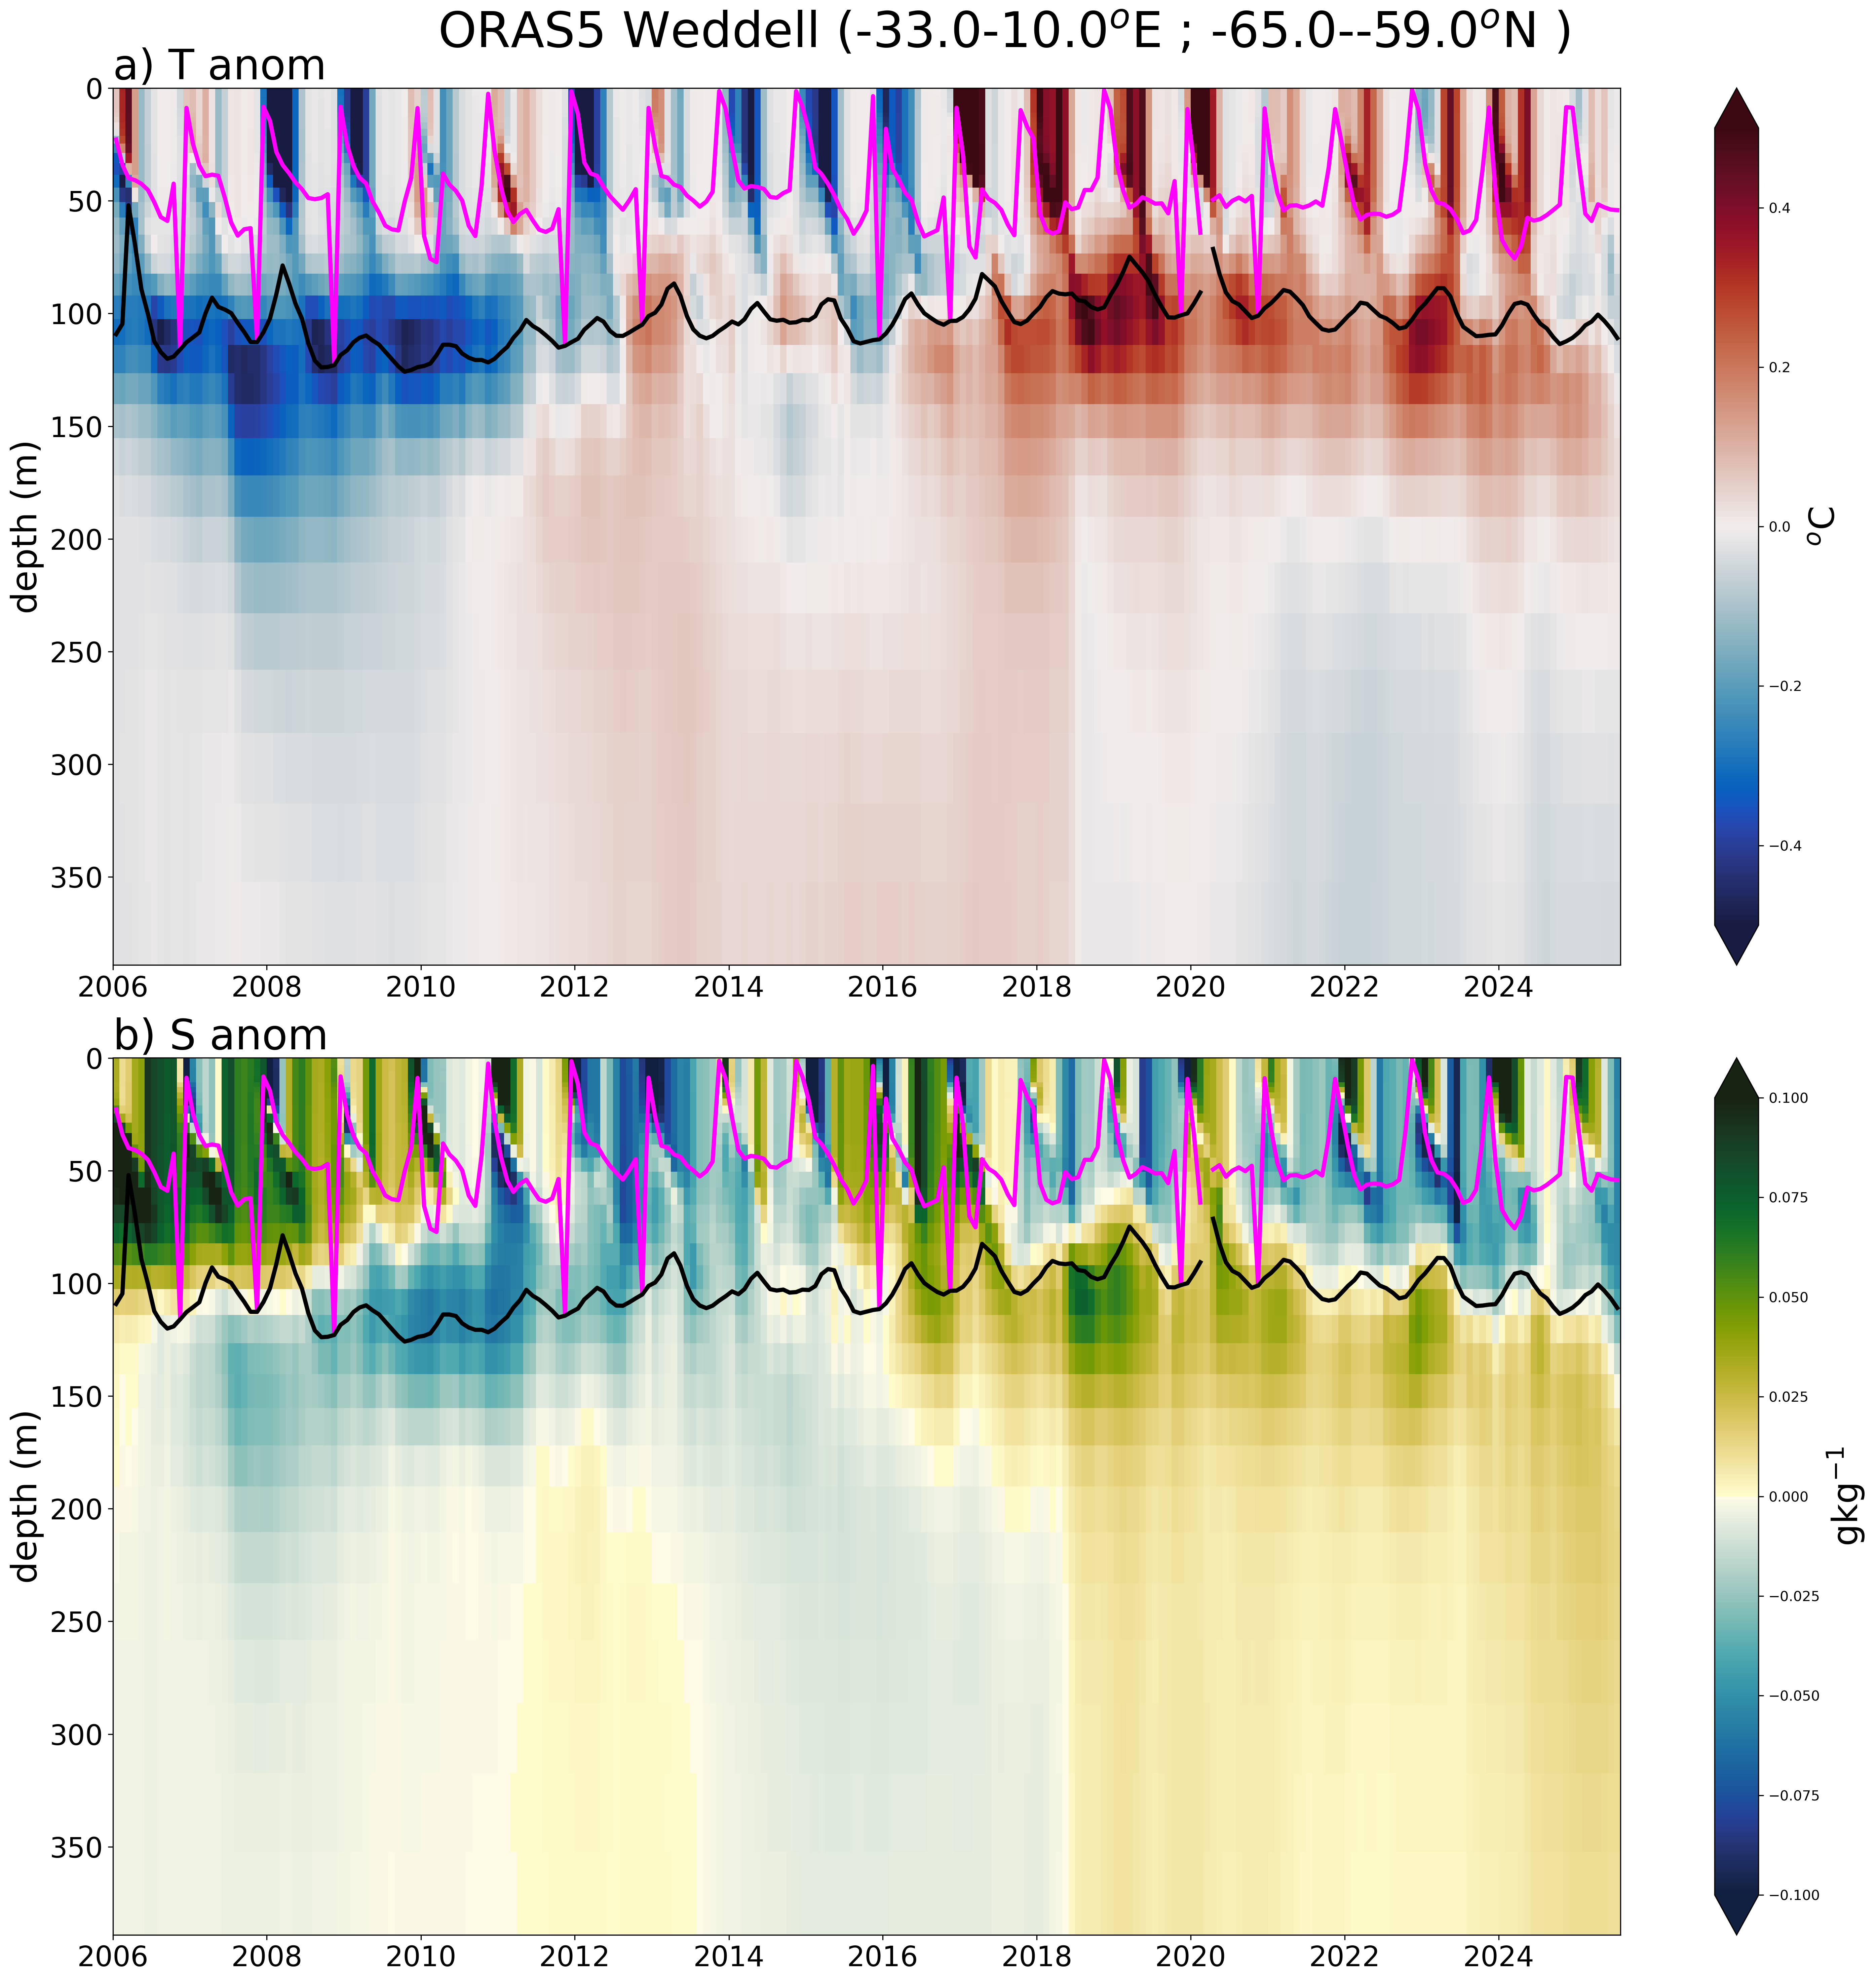

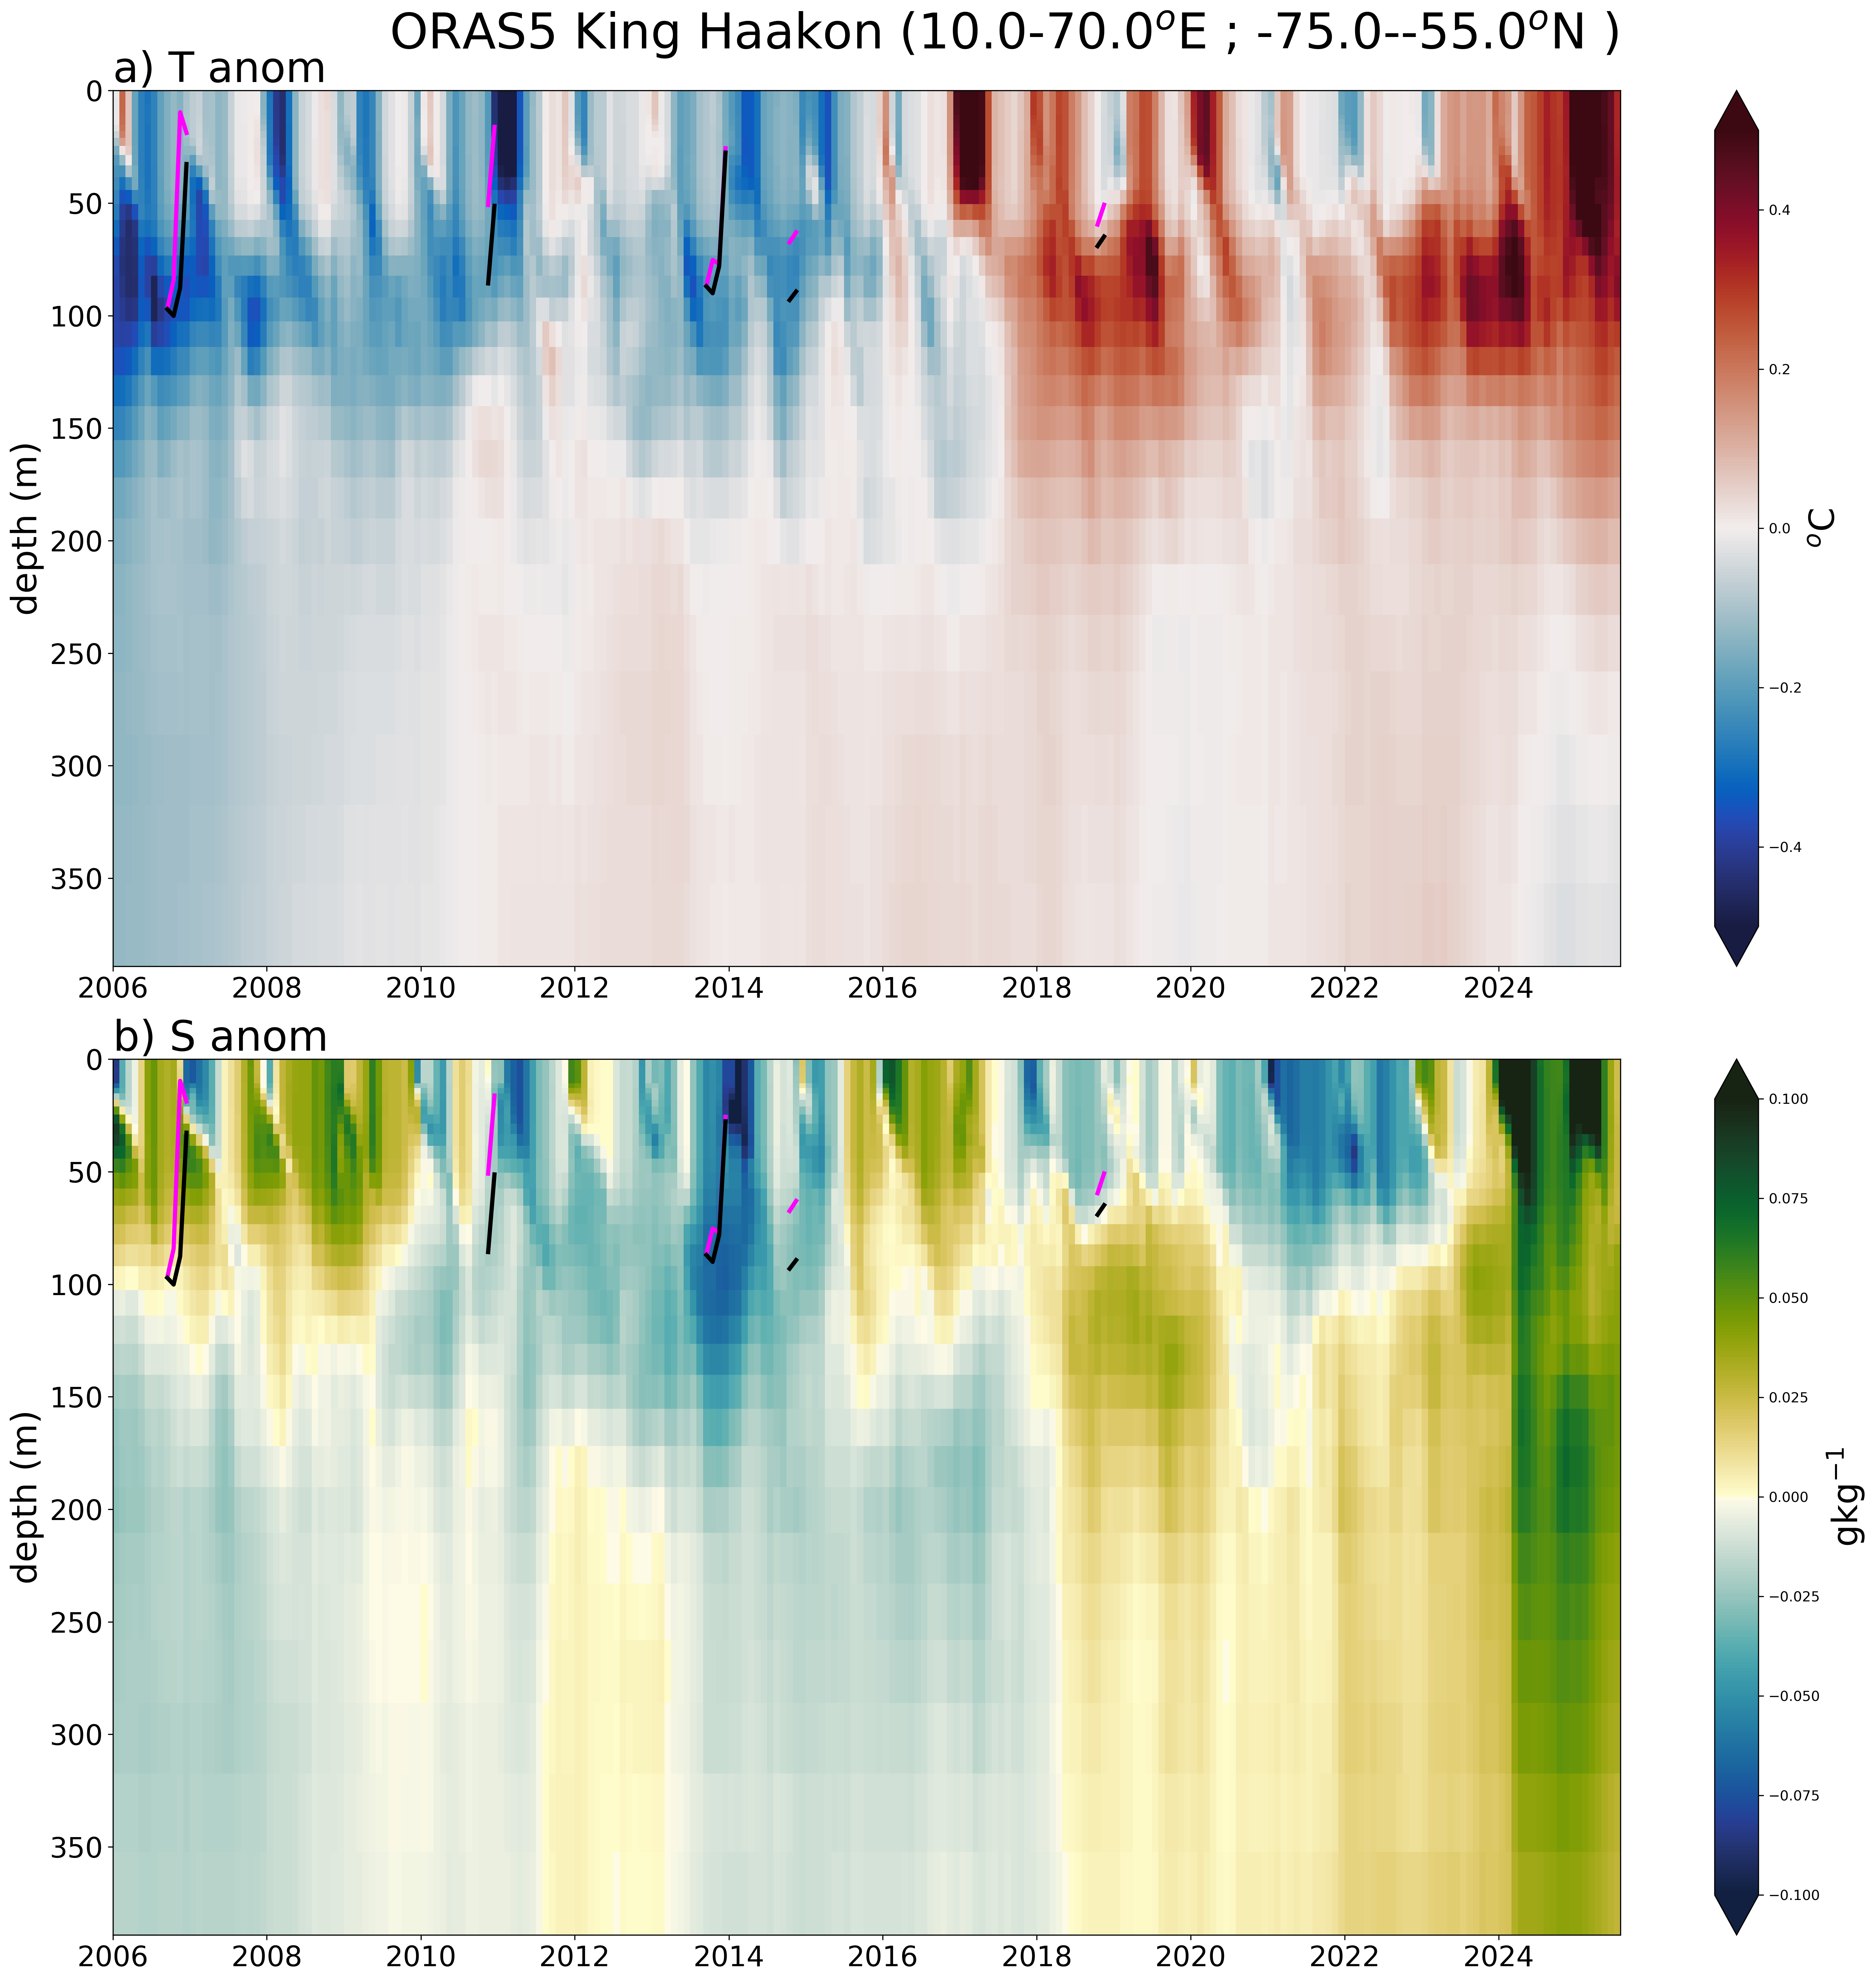

In [50]:
for splot in sector_mean.sector.values:
    sector_anom_plot(splot)
    plt.savefig(diro+src+'_'+splot+'_depth-time_sector_mean_anoms.png')




In [51]:
Client.close()

2025-09-15 15:30:06,895 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-09-15 15:30:06,897 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-09-15 15:30:06,898 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-09-15 15:30:06,917 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-09-15 15:30:06,919 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-09-15 15:30:06,920 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-09-15 15:30:06,933 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-09-15 15:30:06,934 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-09-15 15:30:06,935 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-09-15